In [1]:
## import stuff
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# This is Ass. 4 - Correlation and regression
## Hausarbeit im Modul Data Analytics mit Python SS23

focus is on statistics, correlation and regression 
There are 3 steps to do:
1. Data Preperation
2. Correlation
3. Create multiple regression model for life expectancy
4. Improve regression model and give recommendations to WHO

# 1. Data Preparation
Import and Clean
1. Inspect data + Business understanding
1. Check + handle missing values
1. Detect + handle outliers
1. Check data types + convert
1. handle categorical data

In [2]:
## get data
data = pd.read_csv("04_Assignment_data.csv")
#data.head()
#data.info()
#data.describe()
# Add unique ID to each row
data['ID'] = range(1, len(data) + 1)
# Ensure the column "ID" is the first in the list of columns
data = data[['ID'] + [col for col in data if col != 'ID']]
data.head()

,ID,country,year,status,life_expectancy,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,polio,total_expenditure,diphtheria,hiv/aids,gdp,schooling,population
0,1,Afghanistan,2015,Developing,65.0,263.0,0.010000,71.279624,65.0,831,52.0,8.16,65.0,0.1,584.259210,10.1,33736494.0
1,2,Albania,2015,Developing,77.8,74.0,4.600000,364.975229,99.0,0,99.0,6.00,99.0,0.1,3954.227830,14.2,28873.0
2,3,Algeria,2015,Developing,75.6,19.0,5.288333,0.000000,95.0,63,95.0,7.08,95.0,0.1,4132.762920,14.4,39871528.0
3,4,Angola,2015,Developing,52.4,335.0,5.288333,0.000000,64.0,118,52.0,7.08,64.0,1.8,3695.793748,11.4,2785935.0
4,5,Antigua and Barbuda,2015,Developing,76.4,13.0,5.288333,0.000000,99.0,0,86.0,7.08,99.0,0.2,13566.954100,13.9,NaN


### Data understanding and assumptions
- Life expectancy is described as "Life expectancy of people in years for a particular country and year in percentage", but the values do not show percentage, Im assuming those values are the years average of life expectancy 

In [3]:
#data.info()

In [4]:
##Check for missing values
print(data.isna().sum()) 

ID                          0
country                     0
year                        0
status                      0
life_expectancy             0
adult_mortality             0
alcohol                     0
percentage_expenditure      0
hepatitis_b                 0
measles                     0
polio                       0
total_expenditure           0
diphtheria                  0
hiv/aids                    0
gdp                         0
schooling                 163
population                652
dtype: int64


In [5]:
mean_schooling_per_country = data.groupby('country')['schooling'].mean()
#mean_schooling_per_country
mean_population_per_country = data.groupby('country')['population'].mean()
#mean_population_per_country

In [6]:
# Filter the DataFrame to show only rows where 'schooling' column has missing values
missing_schooling_mean = mean_schooling_per_country.isnull()
# Display the filtered data
pd.set_option('display.max_rows', None)
missing_schooling_mean

country
Afghanistan                                             False
Albania                                                 False
Algeria                                                 False
Angola                                                  False
Antigua and Barbuda                                     False
Argentina                                               False
Armenia                                                 False
Australia                                               False
Austria                                                 False
Azerbaijan                                              False
Bahamas                                                 False
Bahrain                                                 False
Bangladesh                                              False
Barbados                                                False
Belarus                                                 False
Belgium                                                 False


In [7]:
# Filter the DataFrame to show only rows where 'schooling' column has missing values
missing_population_mean = mean_population_per_country.isnull()
# Display the filtered data
pd.set_option('display.max_rows', None)
missing_population_mean

country
Afghanistan                                             False
Albania                                                 False
Algeria                                                 False
Angola                                                  False
Antigua and Barbuda                                      True
Argentina                                               False
Armenia                                                 False
Australia                                               False
Austria                                                 False
Azerbaijan                                              False
Bahamas                                                  True
Bahrain                                                  True
Bangladesh                                              False
Barbados                                                 True
Belarus                                                 False
Belgium                                                 False


### replace missing data
So I was going to replace the missing data from schooling and population with the mean from each country, but my analysis showed me that Im missing all values for quite a few countries. Thus I cannot calculate a mean and replace. A overall mean from all countries would distort my eventual regression too much. Thus im dropping both columns for further analysis

In [8]:
# Drop the 'schooling' and 'population' columns
columns_to_drop = ['schooling', 'population']
data = data.drop(columns=columns_to_drop, axis=1)
#data.head()

In [9]:
## Detect + handle outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
#data.info()

C:\Users\pknuhman\AppData\Local\Temp\ipykernel_28708\4066812279.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]


In [10]:
###Check data types + convert
data.dtypes

ID                          int64
country                    object
year                        int64
status                     object
life_expectancy           float64
adult_mortality           float64
alcohol                   float64
percentage_expenditure    float64
hepatitis_b               float64
measles                     int64
polio                     float64
total_expenditure         float64
diphtheria                float64
hiv/aids                  float64
gdp                       float64
dtype: object

In [11]:
## transform status into numerical
label_encoder = LabelEncoder()
# Fit and transform the 'status' column
data['status_encoded'] = label_encoder.fit_transform(data['status'])
data.dtypes

ID                          int64
country                    object
year                        int64
status                     object
life_expectancy           float64
adult_mortality           float64
alcohol                   float64
percentage_expenditure    float64
hepatitis_b               float64
measles                     int64
polio                     float64
total_expenditure         float64
diphtheria                float64
hiv/aids                  float64
gdp                       float64
status_encoded              int32
dtype: object

In [12]:
# Create a mapping of countries to unique numbers
country_to_id = {country: idx for idx, country in enumerate(data['country'].unique(), 1)}
# Replace country names with their respective numbers
data['country'] = data['country'].map(country_to_id)
#data.head()

In [13]:
## testin the country mapping
filtered = data[data['country'] == 1]
filtered

,ID,country,year,status,life_expectancy,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,polio,total_expenditure,diphtheria,hiv/aids,gdp,status_encoded
0,1,1,2015,Developing,65.0,263.000000,0.01,71.279624,65.0,831,52.0,8.16,65.0,0.1,584.259210,1
183,184,1,2014,Developing,59.9,271.000000,0.01,73.523582,62.0,492,58.0,8.18,62.0,0.1,612.696514,1
366,367,1,2013,Developing,59.9,268.000000,0.01,73.219243,64.0,430,62.0,8.13,64.0,0.1,631.744976,1
559,560,1,2012,Developing,59.5,272.000000,0.01,78.184215,67.0,831,67.0,8.52,67.0,0.1,669.959000,1
742,743,1,2011,Developing,59.2,275.000000,0.01,7.097109,68.0,831,68.0,7.87,68.0,0.1,63.537231,1
925,926,1,2010,Developing,58.8,279.000000,0.01,79.679367,66.0,831,66.0,9.20,66.0,0.1,553.328940,1
1108,1109,1,2009,Developing,58.6,281.000000,0.01,56.762217,63.0,831,63.0,9.42,63.0,0.1,445.893298,1
1291,1292,1,2008,Developing,58.1,287.000000,0.03,25.873925,64.0,831,64.0,8.33,64.0,0.1,373.361116,1
1474,1475,1,2007,Developing,57.5,295.000000,0.02,10.910156,63.0,831,63.0,6.73,63.0,0.1,369.835796,1
1657,1658,1,2006,Developing,57.3,295.000000,0.03,17.171518,64.0,831,58.0,7.43,58.0,0.1,272.563770,1


In [15]:
#data.describe()
#data.dtypes

In [16]:
## Creating new dataframe to drop categorical columns status, which I converted before
data_clean = data
data_clean.head()

,ID,country,year,status,life_expectancy,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,polio,total_expenditure,diphtheria,hiv/aids,gdp,status_encoded
0,1,1,2015,Developing,65.0,263.0,0.010000,71.279624,65.0,831,52.0,8.16,65.0,0.1,584.259210,1
1,2,2,2015,Developing,77.8,74.0,4.600000,364.975229,99.0,0,99.0,6.00,99.0,0.1,3954.227830,1
2,3,3,2015,Developing,75.6,19.0,5.288333,0.000000,95.0,63,95.0,7.08,95.0,0.1,4132.762920,1
3,4,4,2015,Developing,52.4,335.0,5.288333,0.000000,64.0,118,52.0,7.08,64.0,1.8,3695.793748,1
4,5,5,2015,Developing,76.4,13.0,5.288333,0.000000,99.0,0,86.0,7.08,99.0,0.2,13566.954100,1


In [17]:
columns_to_drop = ["status"]
data_clean = data_clean.drop(columns=columns_to_drop)
#data_clean.head()

# 2 Correlation 
1. With which attributes does the life expectancy correlate most strongly?
1. Is this correlation significant?
1. Give the correlation coefficient and the p-value as a number and interpret the result.

In [18]:
## 2.3 correlation coefficient and p values

life_expectancy = data_clean['life_expectancy']  

correlation_results = []

for column in data_clean.columns:
    if column != 'life_expectancy':  # Exclude the target column itself
        column_data = data_clean[column]
        corr_coeff, p_value = pearsonr(life_expectancy, column_data)
        correlation_results.append((column, corr_coeff, p_value))

# Sort the results by correlation coefficient in descending order
correlation_results.sort(key=lambda x: abs(x[1]), reverse=True)

# Print the results
for column, corr_coeff, p_value in correlation_results:
    print(f"Attribute: {column}")
    print(f"Correlation Coefficient: {corr_coeff}")
    print(f"P-value: {p_value}")  

Attribute: hiv/aids
Correlation Coefficient: -0.796938902082895
P-value: 0.0
Attribute: adult_mortality
Correlation Coefficient: -0.6776795157138582
P-value: 0.0
Attribute: diphtheria
Correlation Coefficient: 0.5789522844127736
P-value: 1.346360340200632e-262
Attribute: polio
Correlation Coefficient: 0.5732908048184991
P-value: 2.284259730216137e-256
Attribute: gdp
Correlation Coefficient: 0.5010109365398822
P-value: 1.5735014880248504e-186
Attribute: percentage_expenditure
Correlation Coefficient: 0.48843978610881233
P-value: 5.113194409481426e-176
Attribute: status_encoded
Correlation Coefficient: -0.4831213176180295
P-value: 1.0600893633739086e-171
Attribute: alcohol
Correlation Coefficient: 0.3950893411993938
P-value: 2.339033621028447e-110
Attribute: measles
Correlation Coefficient: -0.3378868010980671
P-value: 2.2401889922223918e-79
Attribute: hepatitis_b
Correlation Coefficient: 0.3151197630781701
P-value: 9.807730347191928e-69
Attribute: total_expenditure
Correlation Coefficien

In [19]:
correlation_matrix = data_clean.corr()
correlation_matrix

,ID,country,year,life_expectancy,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,polio,total_expenditure,diphtheria,hiv/aids,gdp,status_encoded
ID,1.000000,0.054870,0.409015,-0.170289,0.075904,0.027878,-0.036221,-0.204939,0.121556,-0.117554,-0.128609,-0.150464,0.086527,-0.150080,-0.003918
country,0.054870,1.000000,-0.000671,-0.012166,0.016435,-0.065951,-0.064302,-0.026293,0.046107,0.005207,0.039463,-0.011701,-0.039323,-0.027941,-0.030450
year,0.409015,-0.000671,1.000000,-0.076148,0.022264,-0.018877,-0.075950,-0.139608,0.088181,-0.093422,-0.006799,-0.097953,0.027773,-0.085610,-0.000170
life_expectancy,-0.170289,-0.012166,-0.076148,1.000000,-0.677680,0.395089,0.488440,0.315120,-0.337887,0.573291,0.222306,0.578952,-0.796939,0.501011,-0.483121
adult_mortality,0.075904,0.016435,0.022264,-0.677680,1.000000,-0.187971,-0.293870,-0.214673,0.216200,-0.348198,-0.121052,-0.351136,0.596271,-0.297774,0.310207
alcohol,0.027878,-0.065951,-0.018877,0.395089,-0.187971,1.000000,0.378069,0.106352,-0.197193,0.265830,0.308434,0.272948,-0.193443,0.389598,-0.580249
percentage_expenditure,-0.036221,-0.064302,-0.075950,0.488440,-0.293870,0.378069,1.000000,0.122870,-0.194687,0.268385,0.159830,0.268411,-0.295791,0.712940,-0.420621
hepatitis_b,-0.204939,-0.026293,-0.139608,0.315120,-0.214673,0.106352,0.122870,1.000000,-0.266487,0.608008,0.071100,0.647198,-0.278977,0.172066,-0.108121
measles,0.121556,0.046107,0.088181,-0.337887,0.216200,-0.197193,-0.194687,-0.266487,1.000000,-0.320104,-0.161737,-0.315164,0.226305,-0.183792,0.130744
polio,-0.117554,0.005207,-0.093422,0.573291,-0.348198,0.265830,0.268385,0.608008,-0.320104,1.000000,0.164149,0.855849,-0.475611,0.309033,-0.265064


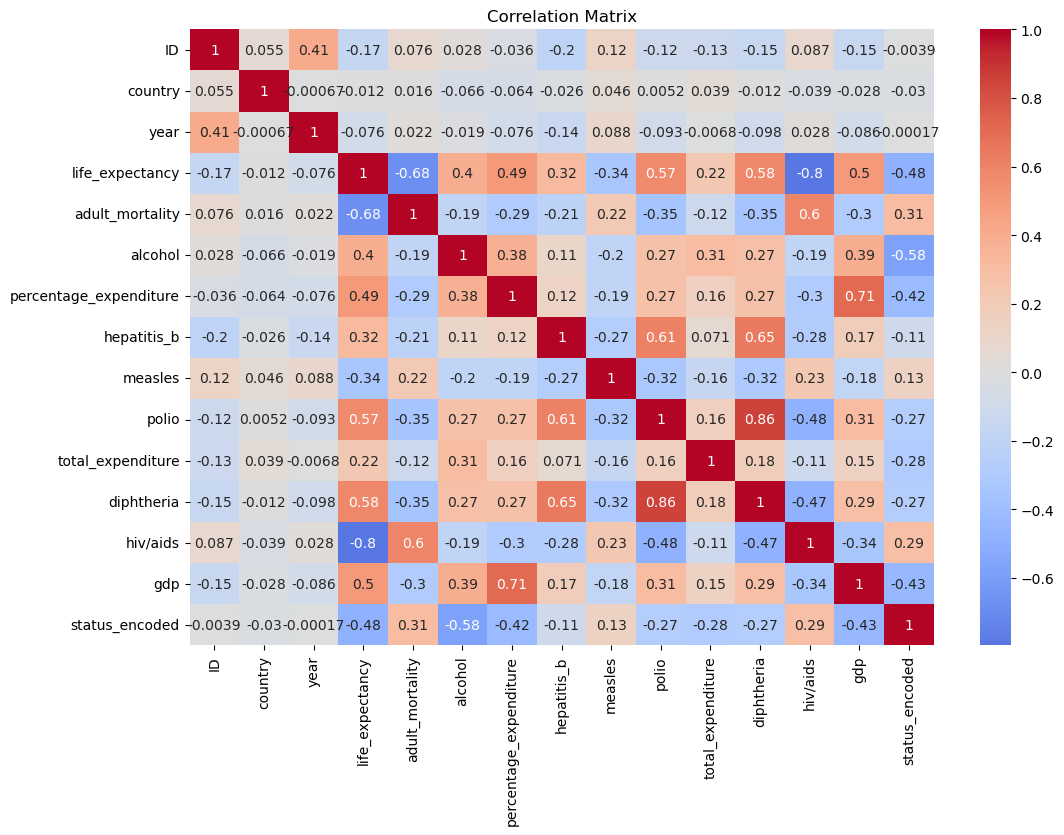

In [20]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

## Interpretation


1. With which attributes does the life expectancy correlate most strongly?
1. Is this correlation significant?

| Value   |      Direction |  
|----------|:-------------:|
|-1.0 |  Perfectly negative | 
| -0.8 |  Strongly negative |  
| -0.5 |  Moderately negative |    
| -0.2 |  No association |  
|0.0  |No association  |  
|+0.2 |Weakly positive  |  
| +0.5 | Moderately positive |  
|  +0.8| Strongly positive |  
| +1.0 | Perfectly positive |  



### Life Expectancy Correlations:
1. <b>life_expectancy and adult_mortality: -0.677680 </b>
<br>There's a moderately to strong negative correlation. This suggests that as adult mortality rates increase, life expectancy tends to decrease, which makes intuitive sense.
1. <b>life_expectancy and alcohol: 0.395089 </b>
<br>Weakly to Moderate positive correlation. This suggests that regions or periods where alcohol consumption is higher tend to have higher life expectancies. However, correlation doesn't imply causation. There could be other confounding factors.
1. <b>life_expectancy and percentage_expenditure: 0.488440 </b>
<br>This shows a moderate positive correlation, indicating that as healthcare expenditure (or some related metric) increases, life expectancy also tends to increase.
1. <b>life_expectancy and hepatitis_b: 0.315120 </b>
<br>A weakly positive correlation, but it's weaker than previous attributes.
1. <b>life_expectancy and polio: 0.573291 </b>
<br>Moderately positive correlation. It implies that higher polio immunization rates (or other associated factors) are associated with higher life expectancy.
1. <b>life_expectancy and diphtheria: 0.578952 </b>
<br> Similarly, there's a moderatley positive correlation between diphtheria immunization (or related factors) and life expectancy.
1. <b>life_expectancy and hiv/aids: -0.796939 </b>
<br> Strongly negative correlation. This indicates that as HIV/AIDS prevalence increases, life expectancy significantly decreases.
1. <b>life_expectancy and gdp: 0.501011 </b>
<br> Moderately positive correlation suggests that higher GDP values are associated with higher life expectancy, which might indicate better healthcare, nutrition, and overall living conditions.
Out of these, life_expectancy has the strongest negative correlation with hiv/aids and the strongest positive correlation with diphtheria and polio.

# 3. Create and interpret a multiple regression model that explains life expectancy

In [21]:
## using Python statsmodels
data_clean.drop(columns=["ID", "country", "year"], inplace=True)  # Drop non-numeric or non-relevant columns

# Define the dependent (y) and independent (X) variables
X = data_clean.drop(columns=["life_expectancy"])
y = data_clean["life_expectancy"]

# Add a constant to the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary statistics of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1169.
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:41:08   Log-Likelihood:                -8295.5
No. Observations:                2938   AIC:                         1.662e+04
Df Residuals:                    2926   BIC:                         1.669e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     68

### 1. Model Fit:
- R-squared: 0.815. This means that the model explains 81.5% of the variance in life expectancy. This is a pretty high value and suggests that the model captures most of the variability of life expectancy.
- Adj. R-squared: 0.814. Adjusted R-squared accounts for the number of predictors in the model and is slightly lower than R-squared, but still very high, suggesting a good model fit.
- F-statistic and Prob (F-statistic): The F-statistic is 1169, and the associated probability is close to 0. This indicates that at least one of the predictors is statistically significant in predicting life expectancy.

### 2. Coefficients:

The coef column gives the change in the dependent variable (life expectancy) for a one-unit change in the predictor, assuming all other predictors are held constant.

- adult_mortality: For every unit increase in adult mortality, life expectancy decreases by 0.0201 years, holding other variables constant.

- alcohol: For every unit increase in alcohol consumption, life expectancy increases by 0.1642 years.

- percentage_expenditure: For every unit increase in percentage expenditure, life expectancy increases by 0.0025 years.

- hepatitis_b: For every unit increase in hepatitis B coverage, life expectancy decreases by 0.0392 years.

- measles: For every unit increase in measles cases, life expectancy decreases by 0.0020 years.

- polio: For every unit increase in polio coverage, life expectancy increases by 0.0467 years.

- total_expenditure: For every unit increase in total expenditure, life expectancy increases by 0.1005 years.

- diphtheria: For every unit increase in diphtheria coverage, life expectancy increases by 0.0823 years.

- hiv/aids: For every unit increase in HIV/AIDS cases, life expectancy decreases dramatically by 6.5079 years. This indicates a strong negative relationship between HIV/AIDS prevalence and life expectancy.

- gdp: For every unit increase in GDP, life expectancy increases marginally by 0.0001 years.

- status_encoded: The encoded status has a negative coefficient, which means one of the status ('developing', since it is encoded as '1') is associated with a 2.5257 years decrease in life expectancy, compared to the other status.

### 3. P>|t| (p-values):

- All predictors have p-values close to 0, which means they are statistically significant in predicting life expectancy at the 5% significance level.

### 4. Model Diagnostics:

- Durbin-Watson: The value of 1.913 is close to 2, which indicates that there is no significant autocorrelation in the residuals.
- Prob(Omnibus): Close to 0, suggesting that the residuals are not normally distributed.
- Skew: A very small value, suggesting residuals are approximately symmetric.
- Kurtosis: Higher than 3, suggesting that the tails of the residual distribution are heavier than a normal distribution (presence of outliers or heavy tails).
- Jarque-Bera (JB): Tests the null hypothesis that the data is normally distributed. The very low p-value suggests residuals are not normally distributed.
- Cond. No.: The condition number is large, suggesting potential multicollinearity or other numerical problems. This means that some predictors might be correlated with others.


### 5. Conclusion:
The model is statistically significant and explains a large proportion of the variability in life expectancy. Almost all predictors are statistically significant, with HIV/AIDS having the most drastic negative impact on life expectancy. The diagnosis suggests some potential issues with multicollinearity, so care should be taken in interpretation, and further investigation into the relationships between predictors might be warranted.


# 4. Now try to improve the regression model. 
1. Describe and justify your approach. Explain and interpret the final model. 
1. Describe what recommendations you can give WHO.

## 4.1 Improvement of model

There are several ways to improve a model:

### Incorporate domain knowledge:

- If I have domain knowledge or access to an expert, they might provide insights that can guide feature selection, engineering, or model choice. For example, certain health metrics or socio-economic variables might be particularly influential on life expectancy in specific contexts.
- Incorporating domain knowledge ensures that the model is both statistically and contextually meaningful.

<strong><u> Not going for this, my domain knowledge is limited and the focus for this assignment is on python skills and not on developing domain knowledge

### Data Quality Check:

- Ensure there are no errors or biases in the data collection process. Incorrect data can lead to misleading regression results.
- Ensuring data quality is foundational; a model is only as good as the data it's built on    
    
<strong><u> So the data overall is more than questionable. As discussed in the class forum the data is generated, hence there is no point in this assignment to boost the data quality

### Cross-validation:

- Ensure that the model is not overfitting the data. Using techniques like k-fold cross-validation can provide a more robust measure of the model's predictive performance on unseen data.
- Cross-validation provides a more realistic assessment of the model's performance.

<strong><u> not going for this, it is not expected. I did it in the ML class of the VAWI course, check out my repo if u would like to know more about my skills in that: https://github.com/Ph1lippK/VAWI

### Inclusion of additional variables:

- Variables not in the current dataset might have a significant effect on life expectancy. This could include variables like nutrition indicators, access to clean water, sanitation, etc.

<strong><u> not going for this, it was discussed in the class forum and it is not expected to include more data. In real life I would extend my data source in order to provide a better modell  
    
### Feature Selection:

- Check for multicollinearity: From the condition number in the provided output, we see a potential issue with multicollinearity. Tools like Variance Inflation Factor (VIF) can be used to identify and drop highly correlated features.
- Addressing multicollinearity can help improve the model's stability and interpretability.
- Regularization: Techniques such as Lasso and Ridge regression can be used. Lasso, in particular, performs both regularization and feature selection.Regularization can prevent overfitting, leading to better generalization on new data.
    
<strong><u> Going for this

### Feature Engineering:

- Transformations: Variables like GDP or percentage expenditure might have a non-linear relationship with life expectancy. Considering polynomial features or log-transformations can help model such relationships.
- Interaction terms: Interactions between variables can sometimes be significant. For instance, the effect of GDP on life expectancy might differ between developing and developed countries.
- Feature engineering can help capture the true relationship between predictors and the response, improving the model's accuracy.
    
<strong><u> Going for this

In [22]:
## Feature Selection
## checking for mc with VIF
# Adding a constant column for the intercept
X = add_constant(data_clean.drop(columns=['life_expectancy']))

# Calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)
# Drop columns with VIF > 10 (common threshold) or as deemed appropriate


    VIF Factor                features
0    91.505819                   const
1     1.635697         adult_mortality
2     1.669812                 alcohol
3     2.147283  percentage_expenditure
4     1.806345             hepatitis_b
5     1.177607                 measles
6     3.968915                   polio
7     1.145923       total_expenditure
8     4.322621              diphtheria
9     1.843707                hiv/aids
10    2.220832                     gdp
11    1.756225          status_encoded


So no columns to drop (ಥ﹏ಥ)

In [23]:
# Going for Ridge Regression
# Prepare the features and target variable
X = data_clean.drop(columns='life_expectancy') 
y = data_clean['life_expectancy']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Ridge Regression model
ridge = Ridge(alpha=1.0) 

# Fit the model
ridge.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = ridge.predict(X_train_scaled)
y_pred_test = ridge.predict(X_test_scaled)

# Calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Training MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

# check the coefficients
coefficients = ridge.coef_
print(f"Ridge Coefficients: {coefficients}")


Training MSE: 16.399307773342183
Test MSE: 17.538717537860098
Ridge Coefficients: [-2.26793068  0.63410324  0.96804982 -0.44499202 -0.66355623  0.73168135
  0.26649728  1.20936296 -4.29569581  0.55087989 -0.95026288]


In [24]:
# 1. Get R^2
r2 = ridge.score(X_test_scaled, y_test)
print(f"R^2: {r2}")
# 2. Calculate Adjusted R^2
n, k = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(f"Adjusted R^2: {adjusted_r2}")
## So those values r actually lower than my initial statsmodels regression

R^2: 0.8081416901467062
Adjusted R^2: 0.8044777293682579


#### Feature Creation:
Interaction terms: Interaction terms can help capture the relationship between two variables that affects the dependent variable. GDP and percentage expenditure might interact to affect life expectancy.
#### Feature Transformation:
Log Transformation: If any variable is heavily skewed, it might be useful to apply a logarithmic transformation. Typically, variables like GDP, measles, etc., can be skewed.
Polynomial Features: Some variables might have a non-linear relationship with the dependent variable. You can square or cube them to capture this.
#### Feature Scaling:
Min-Max scaling or standardization can help in getting all variables on the same scale. This can be essential for some algorithms, especially when interaction terms or polynomial features are added.



In [28]:
# Interaction terms
data_clean['gdp_percentage_interaction'] = data_clean['gdp'] * data_clean['percentage_expenditure']

# Log transformation
data_clean['log_gdp'] = np.log1p(data_clean['gdp'])
data_clean['log_measles'] = np.log1p(data_clean['measles'])

# Polynomial features
data_clean['gdp_squared'] = data_clean['gdp']**2
data_clean.head()

,life_expectancy,adult_mortality,alcohol,percentage_expenditure,hepatitis_b,measles,polio,total_expenditure,diphtheria,hiv/aids,gdp,status_encoded,gdp_percentage_interaction,log_gdp,log_measles,gdp_squared
0,65.0,263.0,0.010000,71.279624,65.0,831,52.0,8.16,65.0,0.1,584.259210,1,4.164578e+04,6.372055,6.723832,3.413588e+05
1,77.8,74.0,4.600000,364.975229,99.0,0,99.0,6.00,99.0,0.1,3954.227830,1,1.443195e+06,8.282793,0.000000,1.563592e+07
2,75.6,19.0,5.288333,0.000000,95.0,63,95.0,7.08,95.0,0.1,4132.762920,1,0.000000e+00,8.326943,4.158883,1.707973e+07
3,52.4,335.0,5.288333,0.000000,64.0,118,52.0,7.08,64.0,1.8,3695.793748,1,0.000000e+00,8.215221,4.779123,1.365889e+07
4,76.4,13.0,5.288333,0.000000,99.0,0,86.0,7.08,99.0,0.2,13566.954100,1,0.000000e+00,9.515466,0.000000,1.840622e+08


In [27]:
# Model with statsmodels
X = data_clean.drop(columns=['life_expectancy'])
X = sm.add_constant(X)  # Adds a constant column for the intercept
y = data_clean['life_expectancy']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     875.2
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:42:59   Log-Likelihood:                -8268.6
No. Observations:                2938   AIC:                         1.657e+04
Df Residuals:                    2922   BIC:                         1.666e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Interpretation and 4.2 Description what recommendations I can give to the WHO

#### Model Fit:
R-squared: 0.818, slightly higher than before. 
Adj. R-squared: 0.817 slightly higher than before. 
F-statistic and Prob (F-statistic): The F-statistic is 875.2, and the associated probability is close to 0. This is a better value than before (1169)

#### Significant Variables:

- adult_mortality: For every unit increase in adult mortality, life expectancy drops by 0.0198 years. It's crucial to reduce adult mortality to increase life expectancy.
- alcohol: A unit increase in alcohol consumption leads to an increase in life expectancy by 0.1653 years. However, it's important to interpret this with caution. It doesn't mean increasing alcohol consumption will necessarily increase life expectancy; other confounding factors might be at play.
- percentage_expenditure: As the percentage expenditure on health increases, life expectancy also goes up. Governments and policymakers should consider increasing the health budget.
- hepatitis_b, measles, polio, diphtheria: These vaccination-related or disease-related variables affect life expectancy. Emphasizing comprehensive vaccination programs and fighting these diseases can positively impact life expectancy.
- hiv/aids: As expected, a unit increase in HIV/AIDS prevalence leads to a significant drop in life expectancy. More resources need to be allocated to combat HIV/AIDS.
- gdp: While the GDP coefficient is negative, the log_gdp and gdp_squared coefficients suggest a more complex relationship. There might be an inflection point after which increasing GDP starts benefiting life expectancy.
- gdp_percentage_interaction: The interaction term is significant, suggesting that the combined effect of GDP and percentage expenditure affects life expectancy.

#### Variables of Less Significance:

log_measles: This variable is not statistically significant (with a high p-value of 0.953). 

#### Overall Recommendations

1. Public Health: Focus on reducing adult mortality and HIV/AIDS prevalence. This may involve investment in healthcare infrastructure, public health campaigns, and medical research.
1. Economic Policy: Even though the GDP's direct effect is negative, the significance of log_gdp suggests that focusing on sustained economic growth can be beneficial for life expectancy.
1. Vaccination: Strengthen vaccination programs, especially for Hepatitis B, Polio, and Diphtheria.
1. Health Expenditure: Increase health expenditure as a percentage of the total budget to positively impact life expectancy.
1. Alcohol Consumption: Further research may be needed to determine the context behind the positive relationship between alcohol and life expectancy. It may reflect a higher quality of life, better healthcare, or other confounding factors in countries with higher alcohol consumption.